In [4]:
from rac.experiment_data import ExperimentReader
start_index = 1
exp_reader = ExperimentReader(["rand"])
datasets = {"20newsgroups": 20, "cifar10": 5, "mnist": 6, "cardiotocography": 10, "yeast": 10, "breast_cancer": 2, "ecoli": 8, "forest_type_mapping": 4, "mushrooms": 5, "user_knowledge": 2}
for dataset, K_init in datasets.items():
    config = {
        "general_options": {
            "experiment_name": "info_gain_exp",
            "num_repeats": 14,
            "n_workers": 14,
            "local": True,
            "verbose": False
        },
        "experiment_options": {
            "seed": 33,
            "num_feedback": 0.001,
            "noise_level": [0.0, 0.4, 0.6],
            "persistent_noise_level": 0.0,
            "save_matrix_data": False,
            "infer_sims": [False],
            "predict_sims": False,
            "clustering_alg": "mean_field",
            "mean_field_beta": [50],
            "info_gain_beta": [1],
            "info_gain_lambda": [50],
            "info_gain_lambda2": [1],
            "running_avg": True,
            "num_edges_info_gain": [10],
            "iterate_mf": [True]
        },
        "sim_init_options": {
            "K_init": K_init,
            "sim_init": [0.01, 0.1],
            "sim_init_type": ["zeros", "uniform_random", "custom"]
        },
        "query_strategy_options": {
            "acq_fn": ["unif", "freq", "maxmin", "maxexp", "info_gain", "entropy", "cluster_freq", "cluster_uncert", "cluster_incon"],
            "eps": 0.3,
            "beta": 1,
            "tau": [7],
            "alpha": 1
        },
        "dataset_options": {
            "dataset": dataset,
        }
    }


    start_index = exp_reader.generate_experiments(
        folder="../configs/info_gain_exp/", 
        options_to_keep=[],
        start_index=start_index,
        **config
    )

In [5]:
from rac.experiment_data import ExperimentReader
exp_reader = ExperimentReader(["rand"])

#"acq_fn": ["unif", "freq", "maxmin", "maxexp", "info_gain_object", "info_gain_edge", "entropy", "cluster_freq", "cluster_uncert", "cluster_incon"],
start_index = 1
config = {
    "general_options": {
        "experiment_name": "info_gain_exp",
        "num_repeats": 14,
        "n_workers": 14,
        "local": True,
        "verbose": False
    },
    "experiment_options": {
        "seed": 33,
        "num_feedback": 0.001,
        "noise_level": [0.0, 0.4, 0.6],
        "persistent_noise_level": 0.0,
        "save_matrix_data": False,
        "infer_sims": [False],
        "predict_sims": False,
        "clustering_alg": "mean_field",
    },

    "sim_init_options": {
        "K_init": 10,
        "sim_init": [0.01],
        "sim_init_type": ["zeros"]
    },
    "query_strategy_options": {
        "acq_fn": ["freq", "info_gain_object", "info_gain_edge"],
        "eps": 0.3,
        "beta": 1,
        "tau": [7],
        "alpha": 1,

        "sparse_sim_matrix": [True],
        "mean_field_beta": [50],
        "info_gain_lambda": [50],
        "running_avg": True,
        "num_edges_info_gain": [20],
        "U_size": [0.5, 1],
        "G_size": [0],
        "info_gain_object_mode": ["uniform"],
        "info_gain_pair_mode": ["uniform"],
        "mf_iterations": [1, 10, 20],
    },
    "dataset_options": {
        "dataset": "synthetic",
        "n_samples": 500,
        "n_clusters": 10,
        "class_balance": None
    }
}


start_index = exp_reader.generate_experiments(
    folder="../configs/info_gain_exp/", 
    options_to_keep=[],
    start_index=start_index,
    **config
)

In [1]:
from rac.experiment_data import ExperimentReader
metrics = ["rand", "ami"]
ac = ExperimentReader(metrics=metrics)

datasets = {"20newsgroups": 20, "cifar10": 5, "mnist": 6, "cardiotocography": 10, "yeast": 10, "breast_cancer": 2, "ecoli": 8, "forest_type_mapping": 4, "mushrooms": 5, "user_knowledge": 2, "synthetic": 10}
for dataset, K_init in datasets.items():

    if dataset == "synthetic":
        dataset_options = {
            "dataset": dataset,
            "n_samples": 500,
            "n_clusters": 10,
            "class_balance": None
        }
    else:
        dataset_options = {
            "dataset": dataset,
        }

    config = {
        "general_options": {
            "experiment_name": "info_gain_exp",
            "num_repeats": 14,
            "n_workers": 14,
            "local": True,
            "verbose": False
        },
        "experiment_options": {
            "seed": 33,
            "num_feedback": 0.001,
            "noise_level": [0.0, 0.4, 0.6, 0.8],
            "persistent_noise_level": 0.0,
            "save_matrix_data": False,
            "infer_sims": [False],
            "predict_sims": False,
            "clustering_alg": "mean_field",
            "mean_field_beta": [50],
            "info_gain_beta": [1],
            "info_gain_lambda": [50],
            "info_gain_lambda2": [1],
            "running_avg": True,
            "num_edges_info_gain": [10],
            "iterate_mf": [True]
        },
        "sim_init_options": {
            "K_init": K_init,
            "sim_init": [0.01, 0.1],
            "sim_init_type": ["zeros", "uniform_random", "custom"]
        },
        "query_strategy_options": {
            "acq_fn": ["unif", "freq", "maxmin", "maxexp", "info_gain", "entropy", "cluster_freq", "cluster_uncert", "cluster_incon"],
            "eps": 0.3,
            "beta": 1,
            "tau": [7],
            "alpha": 1
        },
        "dataset_options": dataset_options
    }


    data = ac.read_all_data(folder="../experiment_results_local/info_gain_exp/" + dataset + "/")
    ac.generate_AL_curves(
        data,
        save_location="../plots/info_gain_exp/" + dataset + "/",
        categorize=["noise_level", "sim_init_type", "sim_init"],
        compare=["acq_fn"],
        vary=["x"],
        auc=True,
        summary_method="auc_max_ind",
        indices=[], 
        threshold=1,
        err_style="band",
        marker="o",
        markersize=6,
        capsize=6,
        linestyle="solid",
        **config
    )

c:\github_projects\robust-active-clustering\rac\experiment_data.py:529: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:529: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:529: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:529: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:529: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:529: UserWarning: FixedFormatter should only be used 

no data found in folder


TypeError: 'NoneType' object is not subscriptable

<Figure size 1200x1200 with 0 Axes>

In [3]:
for i in range(1,2):
    print(i)

1


c:\github_projects\robust-active-clustering\rac\experiment_data.py:540: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:540: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:540: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:540: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:540: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\github_projects\robust-active-clustering\rac\experiment_data.py:540: UserWarning: FixedFormatter should only be used 

KeyboardInterrupt: 

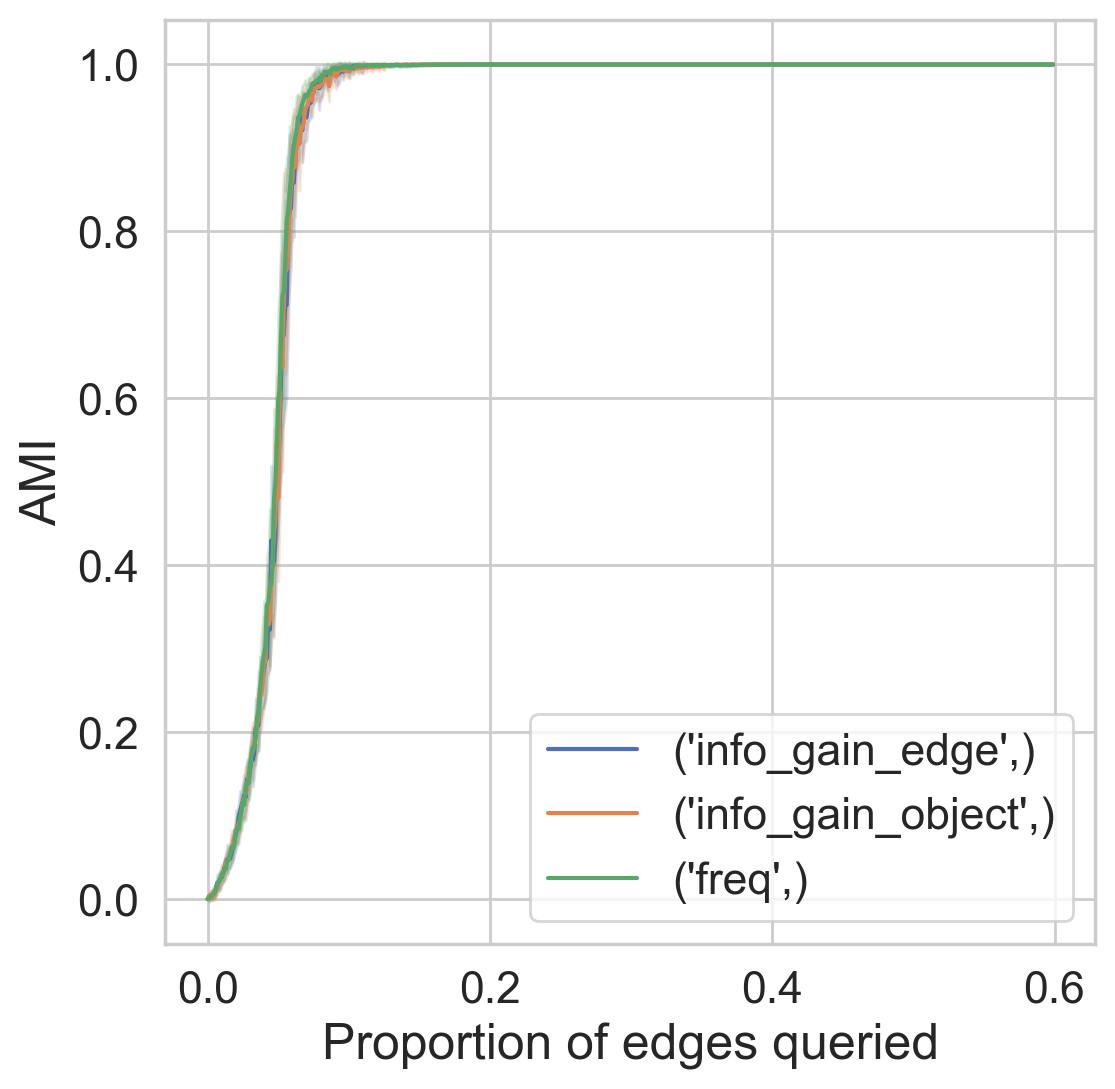

In [1]:
from rac.experiment_data import ExperimentReader
metrics = ["rand", "ami"]
ac = ExperimentReader(metrics=metrics)

config = {
    "general_options": {
        "experiment_name": "info_gain_exp",
        "num_repeats": 14,
        "n_workers": 14,
        "local": True,
        "verbose": False
    },
    "experiment_options": {
        "seed": 33,
        "num_feedback": 0.001,
        "noise_level": [0.0, 0.4, 0.6],
        "persistent_noise_level": 0.0,
        "save_matrix_data": False,
        "infer_sims": [False],
        "predict_sims": False,
        "clustering_alg": "mean_field",
    },

    "sim_init_options": {
        "K_init": 10,
        "sim_init": [0.01],
        "sim_init_type": ["zeros"]
    },
    "query_strategy_options": {
        "acq_fn": ["freq", "info_gain_object", "info_gain_edge"],
        "eps": 0.3,
        "beta": 1,
        "tau": [7],
        "alpha": 1,

        "sparse_sim_matrix": [True],
        "mean_field_beta": [50],
        "info_gain_lambda": [50],
        "running_avg": True,
        "num_edges_info_gain": [0.5, 1, 2, 5],
        "U_size": [0.01, 0.05, 0.1, 0.5],
        "G_size": [0],
        "info_gain_object_mode": ["uniform"],
        "info_gain_pair_mode": ["uniform"],
        "mf_iterations": [1, 5, 10],
    },
    "dataset_options": {
        "dataset": "synthetic",
        "n_samples": 500,
        "n_clusters": 10,
        "class_balance": None
    }
}



data = ac.read_all_data(folder="../experiment_results_local/info_gain_exp/")
ac.generate_AL_curves(
    data,
    save_location="../plots/info_gain_exp/",
    categorize=["noise_level", "num_edges_info_gain", "U_size", "mf_iterations"],
    compare=["acq_fn"],
    vary=["x"],
    auc=True,
    summary_method="auc_max_ind",
    indices=[], 
    threshold=1,
    err_style="band",
    marker="o",
    markersize=6,
    capsize=6,
    linestyle="solid",
    **config
)